In [1]:
import sys
sys.path.insert(0,'../src/')
from curve import *
from utils import *
from multiply_connected_pipe import MultiplyConnectedPipe
import numpy as np
import pickle
from matplotlib import pyplot as plt

In [2]:
with open('./pipes_and_shifts.pickle','rb') as f:
    pipes, shifts = pickle.load(f)

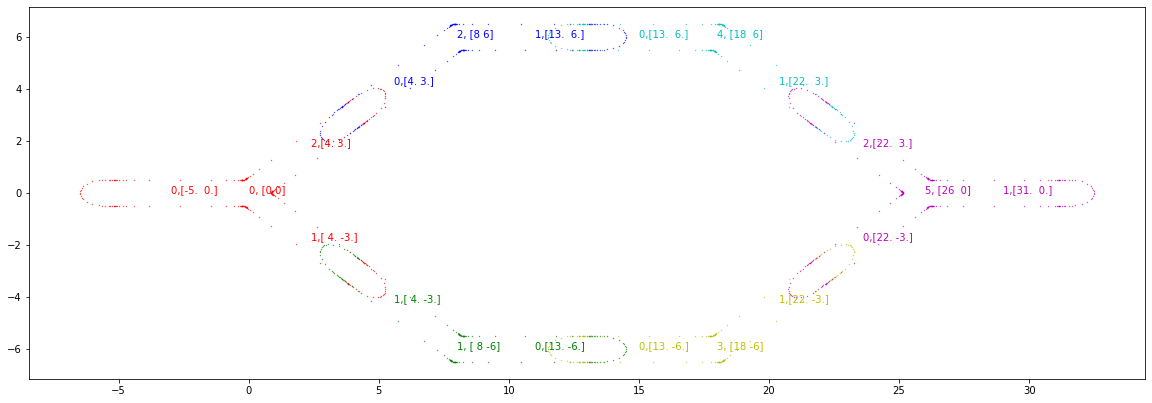

In [3]:
color = ['r','g','b','y','c','m','k']

fig,ax = plt.subplots(figsize=(20,10))
ax.set_aspect('equal')

for a,i,j,c in zip(range(10),pipes,shifts,color):
    panel_break_pts = np.array([p.start_pt + j for p in i.panels])
    ax.scatter(panel_break_pts[:,0], panel_break_pts[:,1],c=c,s=0.1)
    for k,let in enumerate(i.lets):
        ax.text(*(0.6*let.matching_pt + j),f'{k},{let.matching_pt + j}',color=c)
    ax.text(*j,f'{a}, {j}',color=c)

In [4]:
pipe = pipes[0]
panels = pipe.panels
pairs = pipe.mat_vec.close_panel_interactions

In [5]:
bent_panels = [(i,panel) for i,panel in enumerate(panels) if not isinstance(panel.parent, Line)]
stra_panels = [(i,panel) for i,panel in enumerate(panels) if isinstance(panel.parent, Line)]

In [6]:
len(bent_panels), len(stra_panels)

(172, 76)

## developing the integral rules on the straight panels

In [175]:
def transforming_pts(panel,t,with_affine=True):
    scale = pt2cplx(panel.end_pt - panel.start_pt)/2
    shift = pt2cplx(panel.start_pt + panel.end_pt)/2
    
    if with_affine:
        return (t-shift)/scale
    else:
        return t/scale

In [176]:
i,p = bent_panels[5]
n_pts = p.p
m = 2*n_pts

a = p.a
da = p.da
a_trans, da_trans = gauss_quad_rule(n_pts)
a_ref,da_ref  = gauss_quad_rule(m,domain=p.domain)
a_ref_trans, da_ref_trans = gauss_quad_rule(m)

t_ori = p.t
t_trans = transforming_pts(p,t_ori,with_affine=True)
dt_ori = p.dt
dt_trans = transforming_pts(p,dt_ori, with_affine=False)

targ_ori = pipe.t[pairs[i]]
targ_trans = transforming_pts(p,targ_ori,with_affine=True)

t_ref = p.aff_trans(p.x_fn(a_ref),p.y_fn(a_ref),with_affine=True)
dt_ref = p.aff_trans(p.dx_da_fn(a_ref),p.dy_da_fn(a_ref),with_affine=False) * da_ref

t_ref = t_ref[0] + 1j*t_ref[1]
dt_ref = (dt_ref[0] + 1j*dt_ref[1])
t_ref_trans = transforming_pts(p,t_ref,with_affine=True)
dt_ref_trans = transforming_pts(p,dt_ref, with_affine=False)

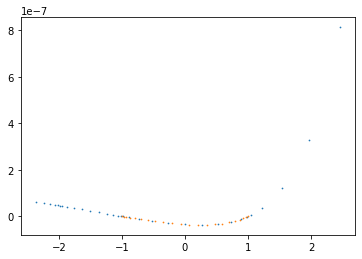

In [177]:
plt.scatter(targ_trans.real,targ_trans.imag,s=0.5)
plt.scatter(t_ref_trans.real,t_ref_trans.imag,s=0.5)

In [246]:
omega = np.exp(20j*np.pi*t_ori)

the interpolation matrix 

In [294]:
weight2coef = np.linalg.solve(np.flip(np.vander(t_trans,N=n_pts),axis=1),np.eye(n_pts))
# given the inputs of weights on the panel, this gives the coefficients of the Vandermonde interpolation
coef2interpolation = np.flip(np.vander(t_ref_trans,N=n_pts),axis=1)
# given the coefficients of polynomial, this evaluates the polynomial at the refined points to interpolate the values. 
interp = coef2interpolation@weight2coef

omega_interp = interp@omega

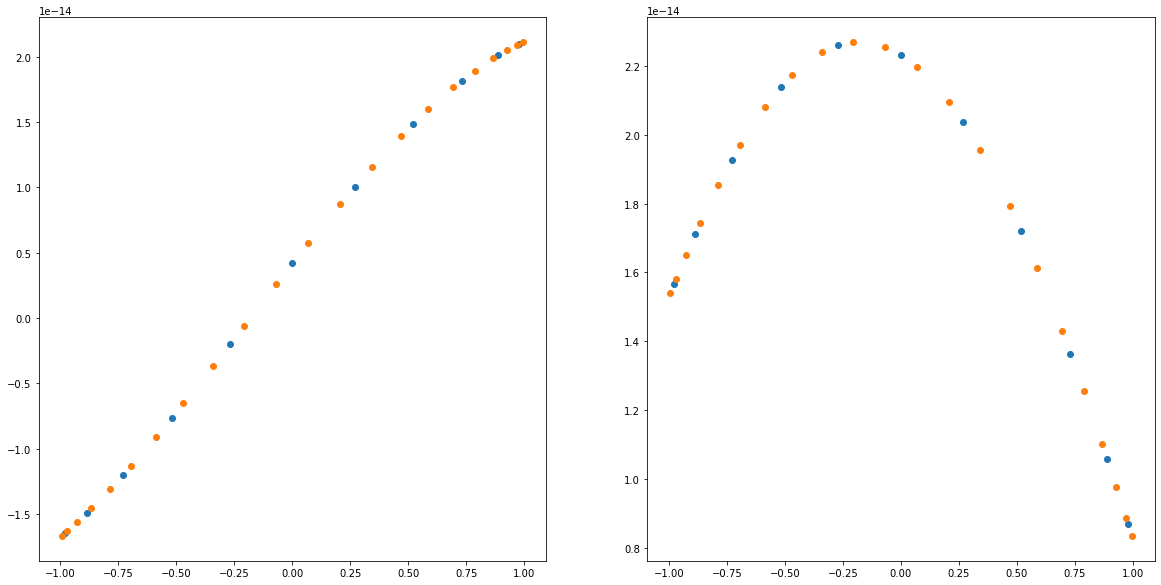

In [296]:
fig, axes = plt.subplots(1,2,figsize=(20,10))
axes[0].scatter(a_trans, omega.real)
axes[0].scatter(a_ref_trans, omega_interp.real)

axes[1].scatter(a_trans, omega.imag)
axes[1].scatter(a_ref_trans, omega_interp.imag)

In [297]:
def analytic_cauchy_integral(targ_trans):
    "not self interactions"
    psi = np.pi/4
    return (1j*psi + np.log((1-targ_trans)/(-1-targ_trans)/np.exp(1j*psi)))

def quad_approx(targ_trans_far,t_ref_trans, dt_ref_trans,m):
    zj = t_ref_trans[:,np.newaxis]
    d_zj = dt_ref_trans[:,np.newaxis]
    x = targ_trans_far[np.newaxis,:]
    return np.sum(zj**(m-1)*d_zj/(zj-x), axis=0)

In [298]:
P = np.zeros((len(targ_ori), m+1), dtype=np.complex128)

targ_trans_close = np.abs(targ_trans) <= 1.1
targ_trans_far   = ~targ_trans_close

P[:,1] = analytic_cauchy_integral(targ_trans)
P[targ_trans_far,m] = quad_approx(targ_trans[targ_trans_far], t_ref_trans, dt_ref_trans, m)

for k in range(1,m):
    # handling the close points 
    P[targ_trans_close,k+1] = P[targ_trans_close,k]*targ_trans[targ_trans_close] + (1 - (-1)**k)/(k)
    # also do things backwards
for k in range(m-1,1,-1):
    P[targ_trans_far, k] = (P[targ_trans_far, k+1] - (1-(-1)**k)/k )/targ_trans[targ_trans_far]
    
R = np.zeros((len(targ_ori), m+1), dtype=np.complex128)
for k in range(1,m+1):
    R[:,k] = (k-1)*P[:,k-1] + (-1)**(k-1)/ (-1-targ_trans) - 1/(1-targ_trans)

P = P[:,1:]
R = R[:,1:]

In [301]:
V = np.flip(np.vander(t_ref_trans,N=m),axis=1)

In [305]:
C = np.linalg.solve(V.T,P.T)
H = np.linalg.solve(V.T,R.T)

In [306]:
scale = pt2cplx(p.end_pt - p.start_pt)/2

IC = C.T@interp
HC = H.T@interp

/tmp/ipykernel_29877/1914625511.py:1: RuntimeWarning: divide by zero encountered in divide
  ret = (omega*dt_trans)[np.newaxis,:]/(t_trans[np.newaxis,:] -targ_trans[:,np.newaxis])**2


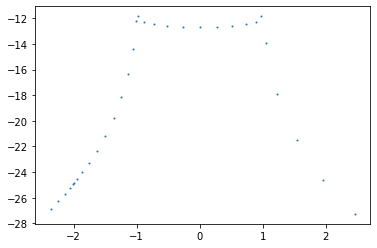

In [313]:
ret = (omega*dt_trans)[np.newaxis,:]/(t_trans[np.newaxis,:] -targ_trans[:,np.newaxis])**2
ret = np.ma.fix_invalid(ret, fill_value=0)
ret = np.sum(ret, axis=1)
# plt.plot(t_trans.real, omega.imag)
plt.scatter(targ_trans.real,np.log10(np.abs((HC@omega)- ret)),s=1)
# plt.scatter(targ_trans.real,ret.real)
# plt.scatter(targ_trans.real,(HC@omega).real)

/tmp/ipykernel_29877/2746926664.py:1: RuntimeWarning: divide by zero encountered in divide
  ret = (omega*dt_trans)[np.newaxis,:]/(t_trans[np.newaxis,:] -targ_trans[:,np.newaxis])


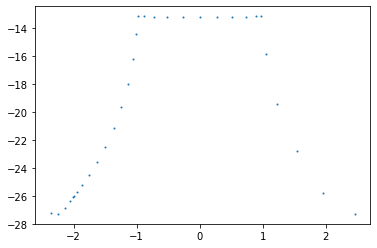

In [314]:
ret = (omega*dt_trans)[np.newaxis,:]/(t_trans[np.newaxis,:] -targ_trans[:,np.newaxis])
ret = np.ma.fix_invalid(ret, fill_value=0)
ret = np.sum(ret, axis=1)
# plt.plot(t_trans.real, omega.imag)
plt.scatter(targ_trans.real,np.log10(np.abs((IC@omega)- ret)),s=1)